# Actividad 4.3 Diagramas de voronoy
**Victor Misael Escalante Alvarado**

In [165]:

import numpy as np
import matplotlib.pyplot as plt
import math


## Funciones y codigo Previo

### Clases Usaddas para la triangulacion

In [166]:
# Clase para los puntos
class Punto:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def show(self):
        return [self.x, self.y]
    
class PuntoConNombre:
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y

    def show(self):
        return [self.name, self.x, self.y]

# Clase para los segmentos
class Segmento:
    def __init__(self, A, B):
        self.A = A
        self.B = B

    def show(self):
        return [self.A.x, self.A.y, self.B.x, self.B.y]

# Clase para los triángulos
class Triangulo:
    def __init__(self, puntos):
        self.puntos = puntos
        self.circuncentro, self.circunradio = calcular_circuncentro_y_radio(*puntos)

### Funciones de la tarea anterior

In [167]:
# Calcula circuncentro y circunradio
# Calcula circuncentro y radio
def calcular_circuncentro_y_radio(p1, p2, p3):
    D = 2 * (p1.x * (p2.y - p3.y) + p2.x * (p3.y - p1.y) + p3.x * (p1.y - p2.y))
    
    if D == 0:
        return None, None
    
    Ux = ((p1.x**2 + p1.y**2) * (p2.y - p3.y) + (p2.x**2 + p2.y**2) * (p3.y - p1.y) + (p3.x**2 + p3.y**2) * (p1.y - p2.y)) / D
    Uy = ((p1.x**2 + p1.y**2) * (p3.x - p2.x) + (p2.x**2 + p2.y**2) * (p1.x - p3.x) + (p3.x**2 + p3.y**2) * (p2.x - p1.x)) / D
    
    radio = math.sqrt((Ux - p1.x)**2 + (Uy - p1.y)**2)
    
    return Punto(Ux, Uy), radio

# Verifica si un punto está dentro o sobre una circunferencia
def punto_dentro_circunferencia(punto, centro, radio):
    distancia = math.sqrt((centro.x - punto.x)**2 + (centro.y - punto.y)**2) # Distancia del punto al circuncentro
    return distancia <= radio  # Retorna True si está dentro del radio

# Funcines para graficar
def graficar_triangulos_y_puntos(puntos, triangulos, deaths):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    for triangulo in triangulos:
        x_values = [punto.x for punto in triangulo.puntos] + [triangulo.puntos[0].x]
        y_values = [punto.y for punto in triangulo.puntos] + [triangulo.puntos[0].y]
        ax.plot(x_values, y_values, 'k-')

    for punto in puntos:
        ax.plot(punto.x, punto.y, 'bo')
        ax.text(punto.x, punto.y, punto.name, fontsize=12, ha='right')
    
    for death in deaths:
        ax.plot(death.x, death.y, 'ro')

    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    plt.show()

def triangulacion_delaunay(puntos):
    triangulos = []
    for i in range(len(puntos)):
        for j in range(i + 1, len(puntos)):
            for k in range(j + 1, len(puntos)):
                p1, p2, p3 = puntos[i], puntos[j], puntos[k]
                centro, radio = calcular_circuncentro_y_radio(p1, p2, p3)
                if centro is None:
                    continue
                es_delaunay = all(math.sqrt((centro.x - p.x)**2 + (centro.y - p.y)**2) >= radio for p in puntos if p not in [p1, p2, p3])
                if es_delaunay:
                    triangulos.append(Triangulo([p1, p2, p3]))
    return triangulos



### Funciones para cargar archivos

In [168]:
# Lectura de archivos
def cargar_puntos(archivo):
    puntos = []
    with open(archivo, 'r') as file:
        num_points = int(file.readline().strip())
        for line in file:
            x, y = map(float, line.strip().split())
            puntos.append(Punto(x, y))
    return puntos

def cargar_puntos_name(archivo):
    puntos = []
    with open(archivo, 'r') as file:
        # ignoarmoa la primera linea
        file.readline()
        for line in file:
            name, x, y = line.strip().split(',')
            puntos.append(punto_name(name, float(x), float(y)))
    return puntos

def cargar_deaths(archivo):
    puntos = []
    with open(archivo, 'r') as file:
        # ignoarmoa la primera linea
        file.readline()
        for line in file:
            name, x, y = line.strip().split(',')
            puntos.append(Punto(float(x), float(y)))
    return puntos




## Funciones y Codigo para el diagrama de voronoi

### Funciones nuevas partiendo de una triangulacion

In [169]:
# Añadir estos cuatro puntos como el límite de la ciudad
def obtener_limites(puntos):
    min_x = min(p.x for p in puntos) - 0.01
    max_x = max(p.x for p in puntos) + 0.01
    min_y = min(p.y for p in puntos) - 0.01
    max_y = max(p.y for p in puntos) + 0.01
    return [
        Punto(min_x, min_y),
        Punto(min_x, max_y),
        Punto(max_x, min_y),
        Punto(max_x, max_y)
    ]

# Función para calcular el bisector entre dos puntos
def calcular_bisector(p1, p2):
    # Calcula el punto medio
    mid_x = (p1.x + p2.x) / 2
    mid_y = (p1.y + p2.y) / 2
    # La pendiente perpendicular
    dx = p2.x - p1.x
    dy = p2.y - p1.y
    if dy == 0:  # Caso especial: pendiente vertical
        return (1, 0, -mid_x)
    elif dx == 0:  # Caso especial: pendiente horizontal
        return (0, 1, -mid_y)
    # Ecuación de la recta bisectora: ax + by + c = 0
    a = -dy
    b = dx
    c = -(a * mid_x + b * mid_y)
    return (a, b, c)

# Función para encontrar intersección de dos líneas
def encontrar_interseccion(bisector1, bisector2):
    a1, b1, c1 = bisector1
    a2, b2, c2 = bisector2
    det = a1 * b2 - a2 * b1
    if det == 0:  # Las rectas son paralelas
        return None
    x = (b2 * c1 - b1 * c2) / det
    y = (a1 * c2 - a2 * c1) / det
    return Punto(x, y)

# Construir el diagrama de Voronoi
def construir_voronoi(triangulos):
    celdas = {}

    for tri in triangulos:

        for punto in tri.puntos:

            if punto not in celdas:
                celdas[punto] = []
            celdas[punto].append(tri.circuncentro)
    return celdas

# Asignar cada punto de 'deaths.csv' a su celda de Voronoi más cercana
def asignar_puntos_a_celdas(puntos_deaths, celdas):
    asignaciones = []
    for death in puntos_deaths:
        dist_min = float('inf')
        celda_asignada = None
        for sitio, vertices in celdas.items():
            dist = math.sqrt((sitio.x - death.x)**2 + (sitio.y - death.y)**2)
            if dist < dist_min:
                dist_min = dist
                celda_asignada = sitio
        asignaciones.append((death, celda_asignada))
    return asignaciones




### la misma grafica pero mas de cerca

In [170]:
# Graficar el diagrama de Voronoi
def graficar_voronoi(puntos, celdas, puntos_deaths, asignaciones):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    colores = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, (sitio, vertices) in enumerate(celdas.items()):
        color = colores[i % len(colores)]
        x_vals = [v.x for v in vertices]
        y_vals = [v.y for v in vertices]
        ax.fill(x_vals, y_vals, color=color, alpha=0.3)
        ax.plot(sitio.x, sitio.y, 'bo')  # Sitios de Voronoi en azul
    for death, sitio in asignaciones:
        ax.plot(death.x, death.y, 'ro')
        ax.plot([death.x, sitio.x], [death.y, sitio.y], 'k--', linewidth=0.5)
    plt.show()
# Obtener todos los puntos (tanto de los sitios de Voronoi como de los puntos de 'deaths')
puntos_x = [p.x for p in puntos] + [death.x for death in puntos_deaths]
puntos_y = [p.y for p in puntos] + [death.y for death in puntos_deaths]

# Calcular límites con un margen adicional
margen = 0.0005  # Ajusta este valor según lo que desees
xmin, xmax = min(puntos_x) - margen, max(puntos_x) + margen
ymin, ymax = min(puntos_y) - margen, max(puntos_y) + margen

# Graficar el diagrama de Voronoi con límites
def graficar_voronoi_con_limites(puntos, celdas, puntos_deaths, asignaciones, xmin, xmax, ymin, ymax):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    colores = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, (sitio, vertices) in enumerate(celdas.items()):
        color = colores[i % len(colores)]
        x_vals = [v.x for v in vertices]
        y_vals = [v.y for v in vertices]
        ax.fill(x_vals, y_vals, color=color, alpha=0.3)
        ax.plot(sitio.x, sitio.y, 'bo')  # Sitios de Voronoi en azul
    #for death, sitio in asignaciones:
        #ax.plot(death.x, death.y, 'ro')
        #ax.plot([death.x, sitio.x], [death.y, sitio.y], 'k--', linewidth=0.5)
    
    # Establecer límites
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.show()

# Llama a la función con los límites calculados


### Codigo de la triangulacion

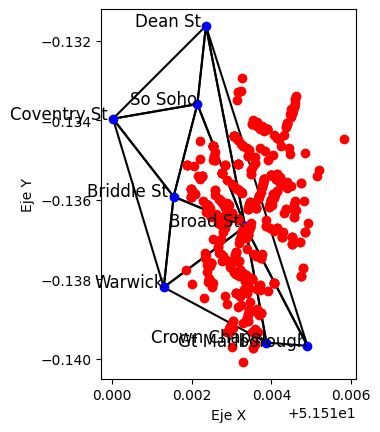

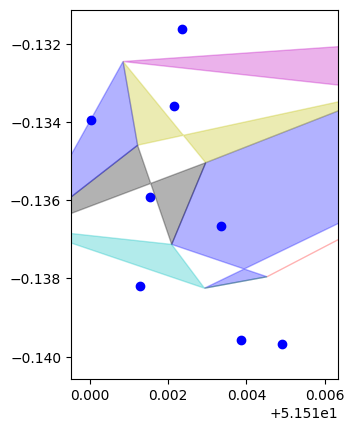

In [171]:

# ---- Inicio del código ---- #
# nombre del archivo
archivo_pumps = "/Users/misa_v/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/Sem 5/Algoritmos_/Scripts/Python/pumps.csv"
archivo_deaths = "/Users/misa_v/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/Sem 5/Algoritmos_/Scripts/Python/deaths.csv"

puntos_name = cargar_puntos_name(archivo_pumps)
puntos_deaths = cargar_deaths(archivo_deaths)

puntos = []
for punto in puntos_name:
    puntos.append(Punto(punto.x, punto.y))

triangulos = triangulacion_delaunay(puntos)
celdas_voronoi = construir_voronoi(triangulos)
asignaciones = asignar_puntos_a_celdas(puntos_deaths, celdas_voronoi)

graficar_triangulos_y_puntos(puntos_name, triangulos, puntos_deaths)

graficar_voronoi_con_limites(puntos_name, celdas_voronoi, puntos_deaths, asignaciones, xmin, xmax, ymin, ymax)
